### 1. Chuẩn bị dữ liệu

In [1]:
from tensorflow import keras 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
df =pd.read_csv(r"C:\Users\NGUYEN MINH TUYET\Stock pj\clean_stock_data.csv")
print(df.head())
print(df.info())
print(df.describe())

         time symbol   open   high    low  close  volume
0  2020-01-02    A32  17.05  17.05  17.05  17.05   300.0
1  2020-01-03    A32  14.92  14.92  14.92  14.92   500.0
2  2020-01-04    A32  14.92  14.92  14.92  14.92     0.0
3  2020-01-05    A32  14.92  14.92  14.92  14.92     0.0
4  2020-01-06    A32  14.92  14.92  14.92  14.92     0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401737 entries, 0 to 3401736
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   symbol  object 
 2   open    float64
 3   high    float64
 4   low     float64
 5   close   float64
 6   volume  float64
dtypes: float64(5), object(2)
memory usage: 181.7+ MB
None
               open          high           low         close        volume
count  3.401737e+06  3.401737e+06  3.401737e+06  3.401737e+06  3.401737e+06
mean   1.713159e+01  1.733371e+01  1.694442e+01  1.715592e+01  3.406808e+05
std    2.503353e+01  2.528087e+01  2.478386e+01  2.503827e+01  2.20563

In [3]:
symbol = "ACB"

# Lọc dữ liệu theo symbol
data = df[df["symbol"] == symbol].copy()

# Sắp xếp theo time
data = data.sort_values("time")

# Reset index và đặt tên
data = data.reset_index(drop=True)
data.index.name = "index"
data['time'] = pd.to_datetime(data['time'], errors='coerce').dt.date

data = data.rename(columns={"time": "date", "symbol":"name"})

data.head()

,date,name,open,high,low,close,volume
index,,,,,,,
0,2020-01-02,ACB,6.58,6.64,6.55,6.64,1163109.0
1,2020-01-03,ACB,6.64,6.70,6.61,6.64,1055528.0
2,2020-01-04,ACB,6.64,6.70,6.61,6.64,0.0
3,2020-01-05,ACB,6.64,6.70,6.61,6.64,0.0
4,2020-01-06,ACB,6.64,6.64,6.49,6.49,1286035.0


### 2. Tổng quan dữ liệu

#### 2.1. Mô tả dữ liệu

In [4]:
print(data.head())
print(data.info())
print(data.describe())

             date name  open  high   low  close     volume
index                                                     
0      2020-01-02  ACB  6.58  6.64  6.55   6.64  1163109.0
1      2020-01-03  ACB  6.64  6.70  6.61   6.64  1055528.0
2      2020-01-04  ACB  6.64  6.70  6.61   6.64        0.0
3      2020-01-05  ACB  6.64  6.70  6.61   6.64        0.0
4      2020-01-06  ACB  6.64  6.64  6.49   6.49  1286035.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2204 entries, 0 to 2203
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2204 non-null   object 
 1   name    2204 non-null   object 
 2   open    2204 non-null   float64
 3   high    2204 non-null   float64
 4   low     2204 non-null   float64
 5   close   2204 non-null   float64
 6   volume  2204 non-null   float64
dtypes: float64(5), object(2)
memory usage: 120.7+ KB
None
              open         high          low        close        volume
count  2204.00000

#### 2.2. Biểu diễn giá mở cửa và đóng cửa

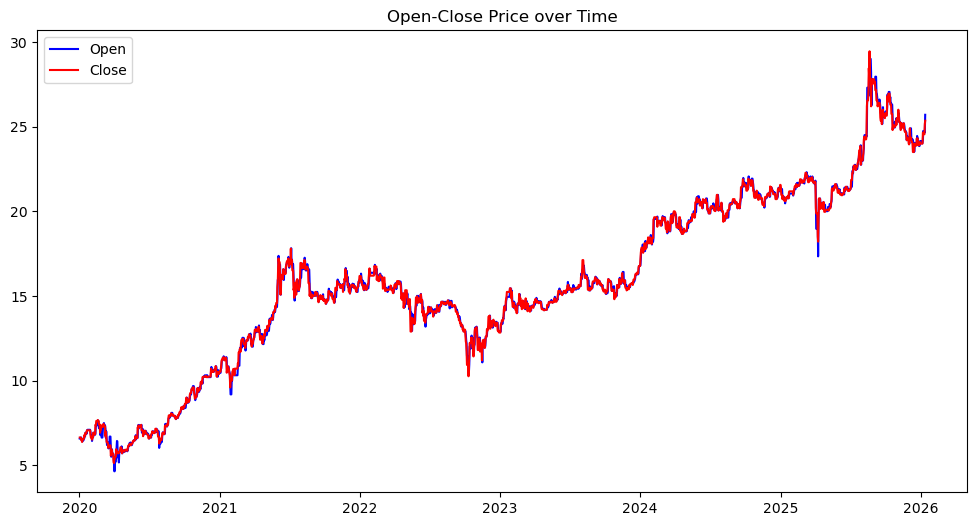

In [5]:
plt.figure(figsize=(12,6))
plt.plot(data['date'], data['open'], label="Open",color="blue")
plt.plot(data['date'], data['close'], label="Close",color="red")
plt.title("Open-Close Price over Time")
plt.legend()
plt.show()

#### 2.4. Kiểm tra tính tương quan

In [6]:
# Drop non-numeric columns
numeric_data = data.select_dtypes(include=["int64","float64"])

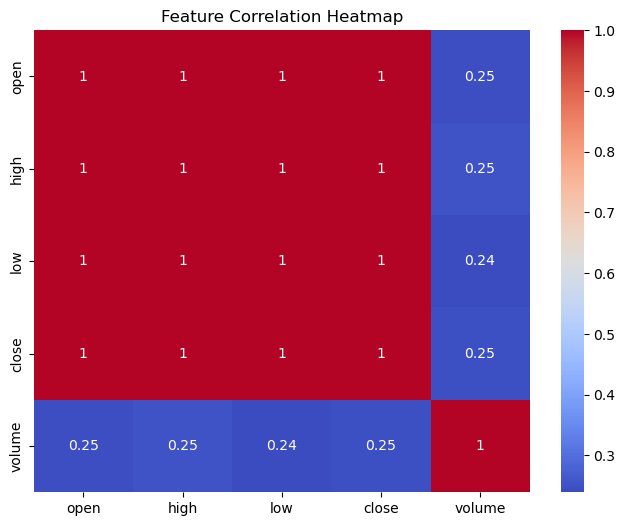

In [7]:
# Check for correlation between features
plt.figure(figsize=(8,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

*=> Các biến giá có tương quan mạnh, phù hợp cho dự đoán; volume có thể bổ sung nhưng không chủ đạo.*

#### 2.5. Chuyển định dạng thời gian về datetime

Text(0.5, 1.0, 'Price over time')

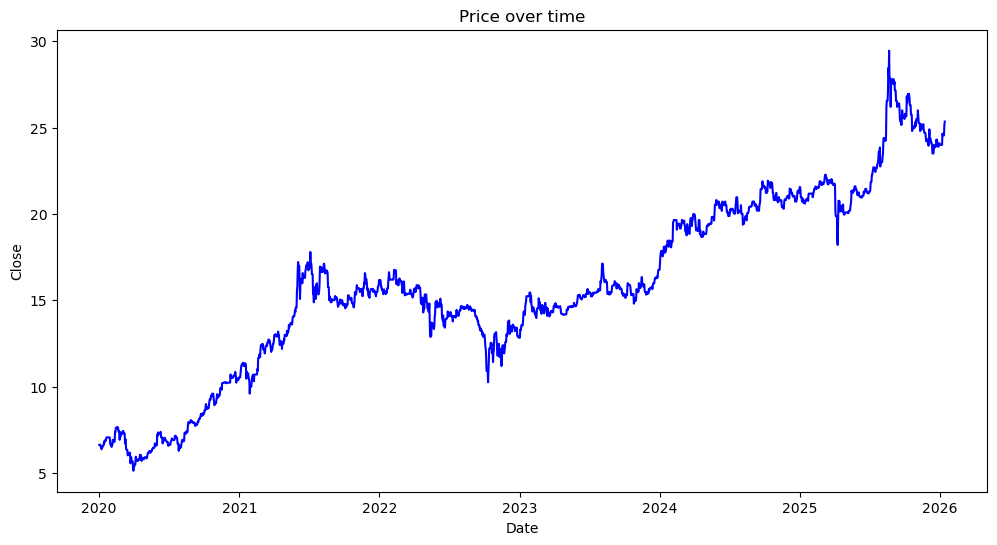

In [8]:
# Convert the Data into Date time then create a date filter
data['date'] = pd.to_datetime(data['date'])

prediction = data.loc[
    (data['date'] > datetime(2020,1,1)) &
    (data['date'] < datetime(2026,1,1))
]

plt.figure(figsize=(12,6))
plt.plot(data['date'], data['close'],color="blue")
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Price over time")

## 3. Dự đoán với ARIMA
### 3.1. Chuẩn bị dữ liệu cho ARIMA

In [9]:
ts = data.set_index('date')['close'] 
ts = ts.asfreq('D')  # Chuyển đổi tần suất dữ liệu theo ngày
#ts = ts.fillna(method='ffill')  # Fill NaN values with forward fill với các ngày là outliers

ts.head()

date
2020-01-02    6.64
2020-01-03    6.64
2020-01-04    6.64
2020-01-05    6.64
2020-01-06    6.49
Freq: D, Name: close, dtype: float64

In [10]:
arima_train_size = int(len(ts) * 0.8)

arima_train = ts.iloc[:arima_train_size]
arima_test = ts.iloc[arima_train_size:]

print("Train size:", len(arima_train))
print("Test size:", len(arima_test))

arima_train.head(), arima_test.head()

Train size: 1763
Test size: 441


(date
 2020-01-02    6.64
 2020-01-03    6.64
 2020-01-04    6.64
 2020-01-05    6.64
 2020-01-06    6.49
 Freq: D, Name: close, dtype: float64,
 date
 2024-10-30    20.97
 2024-10-31    21.22
 2024-11-01    20.80
 2024-11-02    20.80
 2024-11-03    20.80
 Freq: D, Name: close, dtype: float64)

### 3.2. ARIMA not auto

In [11]:
# Kiểm tra tính dừng của chuỗi thời gian bằng ADF test
result = adfuller(arima_train.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -1.0828846705073067
p-value: 0.7218488183670875


*-> p-value >= 0.05 => Chuỗi không dừng => Lấy sai phân*

**Lấy sai phân bậc 1**

In [12]:
at_diff = arima_train.diff().dropna()

adf_result = adfuller(at_diff)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -17.134942399985974
p-value: 7.108229932509166e-30


*-> Chuỗi dừng khi sai phân bậc 1*

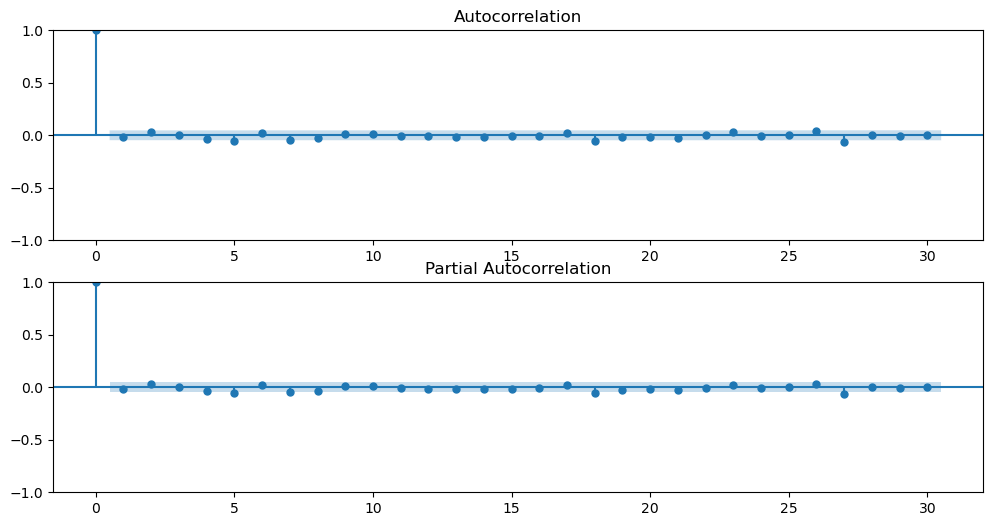

In [13]:
fig, axes = plt.subplots(2,1, figsize=(12,6))
plot_acf(at_diff, ax=axes[0], lags=30)
plot_pacf(at_diff, ax=axes[1], lags=30)
plt.show()


| ARIMA(p,d,q) | AIC | BIC | HQIC |
|--------------|-----|-----|------|
| (1,1,1) | **-619.509** | **-603.090** | **-613.441** |
| (1,1,2) | -615.794 | -583.592 | -607.704 |
| (1,1,4) | -616.420 | -568.845 | -604.287 |
| (2,1,1) | -618.081 | -596.188 | -609.990 |
| (2,1,2) | -618.946 | -591.583 | -608.834 |
| (2,1,4) | -614.452 | -576.152 | -600.296 |
| (4,1,1) | -616.996 | -584.164 | -604.862 |
| (4,1,2) | -605.860 | -567.556 | -591.703 |
| (4,1,4) | -610.960 | -561.718 | -592.761 |

**=> Chọn mô hình có AIC và HQIC nhỏ nhất => ARIMA(1,1,1)**


### 3.3. Kiểm tra tính phù hợp của mô hình

In [14]:
p, d, q = 1, 1, 1

model_arima = sm.tsa.ARIMA(
    arima_train,
    order=(p, d, q),
    trend='n',                    # giá cổ phiếu thường không cần constant khi d=1
    enforce_stationarity=False,   # tránh lỗi hội tụ
    enforce_invertibility=False
)

arima_fit = model_arima.fit()

print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1763
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 312.754
Date:                Tue, 13 Jan 2026   AIC                           -619.509
Time:                        13:17:18   BIC                           -603.090
Sample:                    01-02-2020   HQIC                          -613.441
                         - 10-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7608      0.225     -3.378      0.001      -1.202      -0.319
ma.L1          0.7389      0.232      3.187      0.001       0.285       1.193
sigma2         0.0410      0.001     58.570      0.0

**=> P-value < 0.05 => Mô hình ARIMA(1,1,1) được coi là phù hợp**

### 3.4. Dự báo

In [15]:
# Số bước dự báo = độ dài tập test
n_forecast = len(arima_test)

arima_pred = arima_fit.forecast(steps=n_forecast)
arima_pred.index = arima_test.index  # gán lại index thời gian

MAE: 1.9701
RMSE: 2.8065


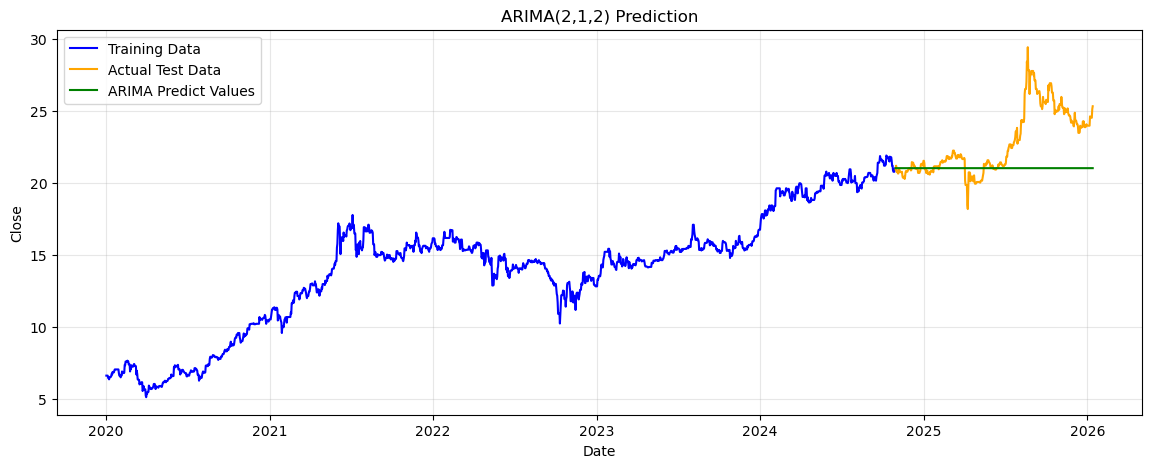

In [16]:
mae_arima = mean_absolute_error(arima_test, arima_pred)
rmse_arima = np.sqrt(mean_squared_error(arima_test, arima_pred))

print(f"MAE: {mae_arima:.4f}")
print(f"RMSE: {rmse_arima:.4f}")

plt.figure(figsize=(14,5))

plt.plot(arima_train, label='Training Data', color='blue')
plt.plot(arima_test, label='Actual Test Data', color='orange')
plt.plot(arima_pred, label='ARIMA Predict Values', color='green')

plt.title('ARIMA(2,1,2) Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

## 4. Dự đoán với LSTM
### 4.1. Chuẩn bị dữ liệu cho LSTM

In [17]:
ts2 = data.set_index('date')['close'].asfreq('D').ffill()

values = ts2.values.reshape(-1, 1)

lstm_train_size = int(len(values) * 0.8)

lstm_train = values[:lstm_train_size]
lstm_test  = values[lstm_train_size:]

print("Train size:", len(lstm_train))
print("Test size:", len(lstm_test))
lstm_train[:5], lstm_test[:5]

Train size: 1763
Test size: 441


(array([[6.64],
        [6.64],
        [6.64],
        [6.64],
        [6.49]]),
 array([[20.97],
        [21.22],
        [20.8 ],
        [20.8 ],
        [20.8 ]]))

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(lstm_train)
test_scaled  = scaler.transform(lstm_test)

**Chia chuỗi thành các nhóm dự đoán (sliding window)**

Mỗi input là 60 ngày giá đóng cửa, output là giá ngày tiếp theo.
(60 ngày là window size phổ biến để dự đoán xu hướng ngắn hạn)

In [19]:
def create_sequences(data, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

LOOKBACK = 30

X_train, y_train = create_sequences(train_scaled, LOOKBACK)
X_test, y_test   = create_sequences(test_scaled, LOOKBACK)


In [20]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1733, 30, 1) (1733,)
(411, 30, 1) (411,)


### 4.2. Xây dựng và huấn luyện mô hình
**Xây dựng mô hình LSTM với Keras**

In [21]:
# Build the Model
model_lstm = keras.models.Sequential()

**First Layer: This is like a brain to help the model understand patterns**
- Number 64: the number of memory cells. Higher number, the more complex problems
- return_sequence: after done, give me the full list of ideas for the next layer
- input_shape: tell the first LSTM layer what kind of date expect\
*=> The first LSTM layer learns patterns from past stock prices over time.*

In [22]:
# First Layer
model_lstm.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

c:\Users\NGUYEN MINH TUYET\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Second Layer: This is another brain, but this time it only gives the final idea, not a list of thoughts**
- Number 64: the number of helpers to help the brain. Higher number, the more complex problems
- return_sequence: this tells the model to return a single output (the final prediction) instead of a sequence\
*=> This layer distills the important patterns form the first layer and prepares to make a final prediction.*

In [23]:
# Second Layer
model_lstm.add(keras.layers.LSTM(64, return_sequences=False))

**Dense Layer: turns complex patterns into a decision**
- Number 128: this is a regular neutral network layer with 128 neurons to help make the final decision
- activation: helps the model introduce non-linearity (ReLU - Rectified Linear Unit)\
*=> This layer helps the model adjust and refine its understanding of the data, learning more complicated trends.*

In [24]:
# 3rd Layer (Dense)
model_lstm.add(keras.layers.Dense(128, activation="relu"))

**Dropout Layout: This layer randomly drops out 50% of the neurons during training**
- Note: This prevents overfitting (when the model memorizes the data too well but struggies with new data).\
*=> It keeps the model from being too sensitive to the training data and makes it perform better*

In [25]:
# 4th Layer (Dropout)
model_lstm.add(keras.layers.Dropout(0.5))

**Final Dense Layer: This layer makes the final prediction**
- Note: a simple layer with 1 neuron that outputs one value - the predicted stock price.\
=> This is the layer that actually makes the prediction for the stock price

**Model Compilation: This compiles for the model to tell it how to learn. We are giving it information to improve**
- optimizer: Adam is a popular optimizer that helps the model adjust its learning. Works well with time-series data.
- loss: MAE measures how far the predictions are from the actual prices. The lower the MAE, the better.
- metrics: This is another performance metric that checks how accurate the predictions are.

In [26]:
# Final Output Layer
model_lstm.add(keras.layers.Dense(1))

model_lstm.summary()
model_lstm.compile(optimizer="adam",
              loss="mae",
              metrics=[keras.metrics.RootMeanSquaredError()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

### 4.3. Kết Quả Huấn Luyện (Training)

In [27]:
training_resid = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1609 - root_mean_squared_error: 0.2305
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0769 - root_mean_squared_error: 0.1042
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0743 - root_mean_squared_error: 0.0992
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0771 - root_mean_squared_error: 0.1055
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0672 - root_mean_squared_error: 0.0895
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0664 - root_mean_squared_error: 0.0899
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0649 - root_mean_squared_error: 0.0890
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0618 - root_mean_squared_error: 0.0849
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0612 - root_mean_squared_error: 0.0842
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0574 - root_mean_squared_error: 0.0773

### 4.4. Dự đoán

In [28]:
y_pred_scaled = model_lstm.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [29]:
y_pred_lstm = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

MAE: 0.4622
RMSE: 0.6086


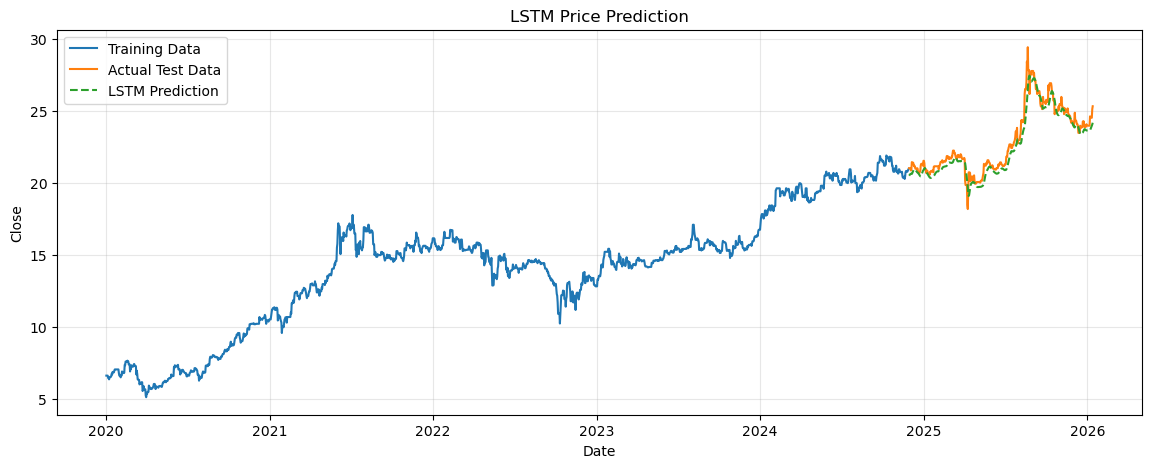

In [30]:
mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_lstm))

print(f"MAE: {mae_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")

test_dates = ts.index[-len(y_test_inv):]
pred_dates = test_dates[-len(y_pred_lstm):]


plt.figure(figsize=(14,5))
train_end_date = ts.index[lstm_train_size + LOOKBACK]

plt.plot(
    ts.index[:lstm_train_size + LOOKBACK],
    ts.iloc[:lstm_train_size + LOOKBACK],
    label='Training Data'
)
plt.plot(test_dates, y_test_inv, label='Actual Test Data')
plt.plot(pred_dates, y_pred_lstm, label='LSTM Prediction', linestyle='--')

plt.title('LSTM Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 5. Dự đoán với Ensemble
### 5.1. Chuẩn bị dữ liệu

In [31]:
min_len = min(len(arima_pred), len(y_pred_lstm))

arima_pred = arima_pred[-min_len:]
y_pred_lstm = y_pred_lstm[-min_len:]


In [32]:
print(type(arima_pred), arima_pred.shape)
print(type(y_pred_lstm), y_pred_lstm.shape)

<class 'pandas.core.series.Series'> (411,)
<class 'numpy.ndarray'> (411, 1)


In [33]:
arima_pred_np = np.array(arima_pred).flatten()
lstm_pred_np  = np.array(y_pred_lstm).flatten()

# Trung bình có trọng số
w_arima = 0.2
w_lstm  = 0.8

y_ensemble = w_arima * arima_pred_np + w_lstm * lstm_pred_np

### 5.2. Dự báo

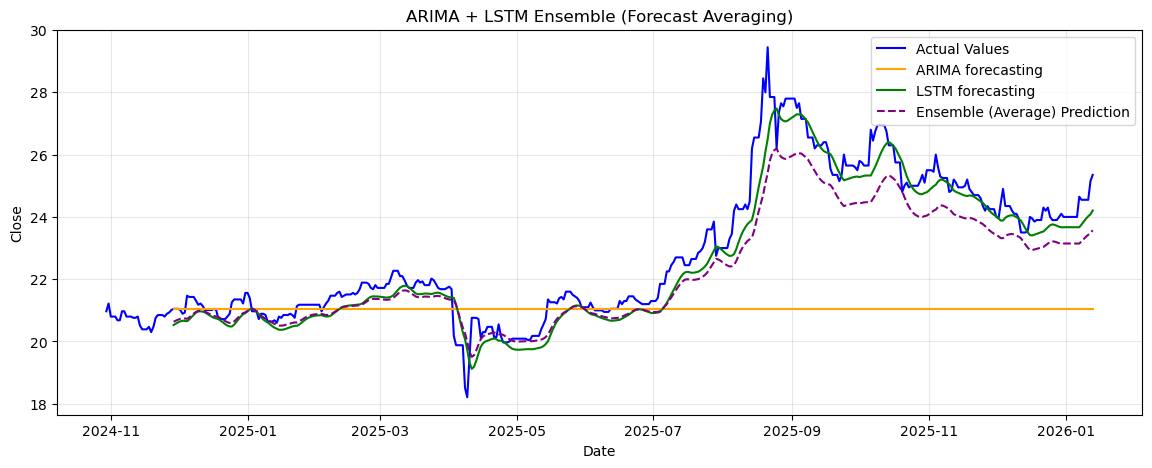

In [34]:
dates = arima_test.index[-len(y_ensemble):]

plt.figure(figsize=(14,5))
plt.plot(arima_test.index, arima_test.values, label='Actual Values', color="blue")
plt.plot(dates, arima_pred, label='ARIMA forecasting', color="orange")
plt.plot(dates, y_pred_lstm, label='LSTM forecasting', color="green")
plt.plot(dates, y_ensemble,'--', label='Ensemble (Average) Prediction', color="purple")

plt.title('ARIMA + LSTM Ensemble (Forecast Averaging)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [35]:
y_true = arima_test.values

y_true      = y_true[-min_len:]
y_ensemble  = y_ensemble[-min_len:]

mae_ensemble = mean_absolute_error(y_true, y_ensemble)
rmse_ensemble = np.sqrt(mean_squared_error(y_true, y_ensemble))

print(f"Ensemble MAE : {mae_ensemble:.4f}")
print(f"Ensemble RMSE: {rmse_ensemble:.4f}")

Ensemble MAE : 0.7224
Ensemble RMSE: 0.9293


## 6. Kết luận và đánh giá
### 6.1. Hiệu suất so sánh các mô hình

In [36]:
df_metrics = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM', 'Ensemble'],
    'MAE':   [mae_arima, mae_lstm, mae_ensemble],
    'RMSE':  [rmse_arima, rmse_lstm, rmse_ensemble]
})

df_metrics


,Model,MAE,RMSE
0,ARIMA,1.970067,2.806453
1,LSTM,0.462178,0.608570
2,Ensemble,0.722416,0.929336


**=> Mô hình LSTM có hiệu suất tốt nhất với MAE và RMSE nhỏ nhất**

### 6.2. Phân tích chi tiết
#### 6.2.1. Mô hình ARIMA(1,1,1)
- Ưu điểm:
    - Đơn giản, dễ diễn giải và nhanh chóng để huấn luyện
    - Thích hợp cho dữ liệu chuỗi thời gian tĩnh sau khi lấy sai phân
    - Không yêu cầu tài nguyên tính toán lớn
- Nhược điểm:
    - Hiệu suất kém hơn so với các mô hình học sâu
    - Khó bắt được các mối quan hệ phi tuyến tính phức tạp trong dữ liệu giá cổ phiếu
    - Giả định tính tuyến tính của chuỗi thời gian
#### 6.2.2. Mô hình LSTM
- Ưu điểm:
    - Hiệu suất tốt nhất với MAE và RMSE nhỏ nhất
    - Khả năng học các mối quan hệ phi tuyến tính và phức tạp
    - Xử lý tốt các phụ thuộc dài hạn trong dữ liệu chuỗi thời gian
    - Kiến trúc với Dropout giúp giảm hiện tượng quá khớp (overfitting)
- Nhược điểm:
    - Yêu cầu dữ liệu huấn luyện lớn hơn
    - Tính toán phức tạp, thời gian huấn luyện dài hơn
#### 6.2.3. Mô hình Ensemble (ARIMA + LSTM)
- Ưu điểm:
    - Kết hợp ưu điểm của cả hai mô hình
    - Giảm rủi ro phụ thuộc vào một mô hình duy nhất
    - Hiệu suất cân bằng hơn
- Nhược điểm:
    - Hiệu suất vẫn thấp hơn LSTM đơn lẻ
    - Tăng độ phức tạp tính toán
    - Cần điều chỉnh trọng số (weights) để tối ưu hóa
### 6.3. Kết quả và khuyến nghị
- Kết luận chính:
    - LSTM là lựa chọn tối ưu cho dự báo giá cổ phiếu trong trường hợp này, với khả năng bắt được các mô hình phức tạp trong dữ liệu tài chính.
    - ARIMA có hạn chế trong việc dự báo giá cổ phiếu do tính chất phi tuyến tính của thị trường.
    - Ensemble không cải thiện hiệu suất do trọng số có lợi cho LSTM, chỉ ra rằng LSTM dominates trong bài toán này.
- Khuyến nghị:
    - Tinh chỉnh hyperparameters của LSTM (số lớp, units, dropout rate)
    - Tăng kích thước dữ liệu huấn luyện
    - Thêm các đặc trưng bổ sung (volume, chỉ số kỹ thuật)
    - Kiểm tra tính ổn định của mô hình trên các giai đoạn thị trường khác nhau